# Анализ сервиса аренды самокатов GoFast.

Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо проанализировать данные и провереть некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 
Сервисом можно пользоваться:

* **без подписки**

-абонентская плата отсутствует;

-стоимость одной минуты поездки — 8 рублей;

-стоимость старта (начала поездки) — 50 рублей;

* **с подпиской Ultra**

-абонентская плата — 199 рублей в месяц;

-стоимость одной минуты поездки — 6 рублей;

-стоимость старта — бесплатно.

**Описание данных**

**Пользователи — users_go.csv**

* user_id — уникальный идентификатор пользователя

* name — имя пользователя

* age — возраст

* city — город

* subscription_type — тип подписки (free, ultra)

**Поeздки — rides_go.csv**

* user_id — уникальный идентификатор пользователя

* distance — расстояние, которое пользователь проехал в текущей сессии (в метрах)

* duration — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»

* date — дата совершения поездки

**Подписки — subscriptions_go.csv**

* subscription_type — тип подписки

* minute_price — стоимость одной минуты поездки по данной подписке

* start_ride_price — стоимость начала поездки

* subscription_fee — стоимость ежемесячного платежа

## Шаг 1. Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import math
import scipy.stats as stats
from scipy import stats as st
from math import factorial
from scipy.stats import binom
from scipy.stats import norm
from matplotlib import rcParams, rcParamsDefault

In [2]:
#Для отображения графиков.
rcParams['figure.figsize'] = 10, 6
%config InlineBackend.figure_format = 'svg'
#Для декорирования графиков.
factor = .8
default_dpi = rcParamsDefault['figure.dpi']
rcParams['figure.dpi'] = default_dpi * factor

Посмотрим общую информацию о таблицах.

### Таблица с пользователями.

In [3]:
try:
    data_users_go = pd.read_csv('/datasets/users_go.csv')
except:
    data_users_go = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
print(data_users_go.columns)
print('___________________________________')
print(data_users_go.info())
print('___________________________________')
print(data_users_go.isna().sum().sort_values(ascending=False))
print('___________________________________')
pd.set_option('display.max_columns', None)
data_users_go

Index(['user_id', 'name', 'age', 'city', 'subscription_type'], dtype='object')
___________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None
___________________________________
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64
___________________________________


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1560,829,Федор,29,Пятигорск,free
1561,809,Юрий,26,Сочи,free
1562,307,Ясмина,19,Краснодар,ultra
1563,47,Юрий,28,Тюмень,ultra


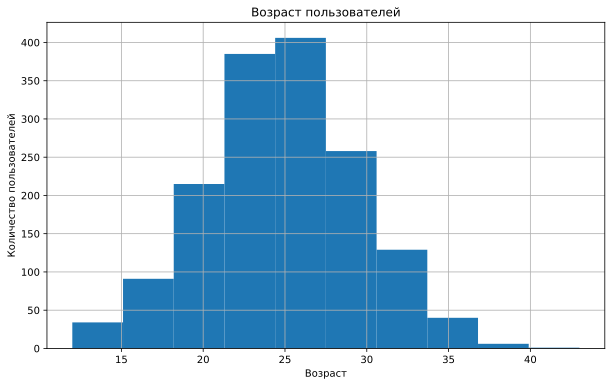

In [4]:
plt.hist(data_users_go['age'], bins = 10)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

In [5]:
count_users_by_city = data_users_go['city'].value_counts()
count_users_by_city

Пятигорск         226
Екатеринбург      206
Ростов-на-Дону    202
Краснодар         196
Сочи              192
Омск              186
Тюмень            185
Москва            172
Name: city, dtype: int64

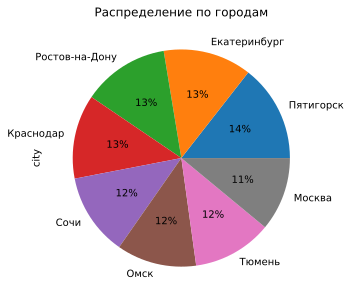

In [6]:
data_users_go['city'].value_counts().plot(
    kind = 'pie', 
    y = count_users_by_city,
    autopct = '%1.0f%%',
    figsize=(5,5), 
    title = 'Распределение по городам');

In [7]:
count_sub = data_users_go['subscription_type'].value_counts()
count_sub

free     846
ultra    719
Name: subscription_type, dtype: int64

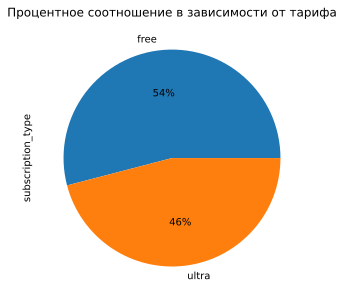

In [8]:
data_users_go['subscription_type'].value_counts().plot(
    kind = 'pie', 
    y = count_sub, 
    autopct = '%1.0f%%', 
    figsize=(5,5),
    title = 'Процентное соотношение в зависимости от тарифа');

### Таблица с поездками.

In [9]:
try:
    data_rides_go = pd.read_csv('/datasets/rides_go.csv')
except:
    data_rides_go = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
print(data_rides_go.columns)
print('___________________________________')
print(data_rides_go.info())
print('___________________________________')
print(data_rides_go.isna().sum().sort_values(ascending=False))
print('___________________________________')
pd.set_option('display.max_columns', None)
data_rides_go

Index(['user_id', 'distance', 'duration', 'date'], dtype='object')
___________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None
___________________________________
user_id     0
distance    0
duration    0
date        0
dtype: int64
___________________________________


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04
18064,1534,2840.423057,21.409799,2021-11-16
18065,1534,3826.185507,18.435051,2021-11-18
18066,1534,2902.308661,16.674362,2021-11-27


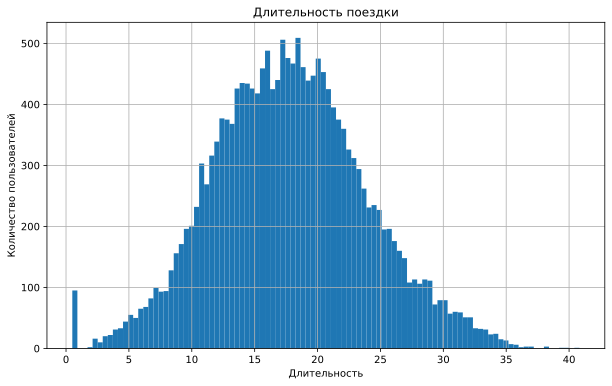

In [10]:
plt.hist(data_rides_go['duration'], bins = 100)
plt.title('Длительность поездки')
plt.xlabel('Длительность')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

### Таблица с подписками.

In [11]:
try:
    data_subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    data_subscriptions_go = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')
print(data_subscriptions_go.columns)
print('___________________________________')
print(data_subscriptions_go.info())
print('___________________________________')
print(data_subscriptions_go.isna().sum().sort_values(ascending=False))
print('___________________________________')
pd.set_option('display.max_columns', None)
data_subscriptions_go    

Index(['subscription_type', 'minute_price', 'start_ride_price',
       'subscription_fee'],
      dtype='object')
___________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
None
___________________________________
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64
___________________________________


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Вывод:** 
Загрузили и проанализировали данные. Основные пользователи — люди в возрасте от 20 до 30 лет. Распределение пользователей по городам примерно одинаковое. Наибольшее количество пользователей находится в Пятигорске, наименьшее — в Москве. Больше пользователей с бесплатным тарифом (54%).

## Шаг 2. Предобработка данных

Пропусков в таблицах нет. Будем обрабатывать только типы значений в столбцах и искать дубликаты.

### Изменение типа данных в столбце date.

Преобразуем столбец date из таблицы data_riders в тип данных datetime.

In [12]:
data_rides_go['date'] = pd.to_datetime(data_rides_go['date'], format = '%Y-%m-%d')

In [13]:
data_rides_go.info()

data_rides_go

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04
18064,1534,2840.423057,21.409799,2021-11-16
18065,1534,3826.185507,18.435051,2021-11-18
18066,1534,2902.308661,16.674362,2021-11-27


### Добавление столбца - номер месяца.

Проверим, за какой период предоставлены данные. Если данные предоставлены за несколько лет, то они могут оказаться в одном и том же месяце.

In [14]:
data_rides_go['date'].dt.year.unique()

array([2021])


Данные предоставлены только за один год, следовательно, ошибки исключены. Добавим номер месяца.

In [15]:
data_rides_go['month'] = data_rides_go['date'].dt.month

In [16]:
data_rides_go['month'].unique()

array([ 1,  4,  8, 10, 11, 12,  3,  6,  7,  2,  5,  9])

### Проверка дубликатов.

Проверяем наличие дубликатов в каждой таблице.

In [17]:
print(data_rides_go.duplicated().sum())
print('___________________________________')
print(data_subscriptions_go.duplicated().sum())
print('___________________________________')
print(data_users_go.duplicated().sum())

0
___________________________________
0
___________________________________
31


Избавимся от обнаруженных дубликатов в таблице data_users_go.

In [18]:
data_users_go.drop_duplicates(inplace=True)
print(data_users_go.duplicated().sum())

0


**Вывод:** Все данные в таблицах присутствуют и не пропущены.

Среди пользователей есть дубликаты, поэтому удалили повторяющиеся строки.

Добавили новый столбец month, который содержит номер месяца.

## Шаг 3. Исследовательский анализ данных

В задании указано, что нужно описать и визуализировать общую информацию о пользователях и поездках:

* Частота встречаемости городов;

* Соотношение пользователей с подпиской и без подписки;

* Возраст пользователей;

* Расстояние, которое пользователь преодолел за одну поездку;

* Продолжительность поездок.

Из таблицы data_users_go были удалены дубликаты, поэтому снова посмотрим на них, чтобы сделать общий вывод.


### Частота встречаемости городов.

In [19]:
count_users_by_city = data_users_go['city'].value_counts()

In [20]:
count_users_by_city

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [21]:
count_users_by_city['rate'] = round(data_users_go['city'].value_counts() / 
                                    count_users_by_city.sum(), 2) * 100

In [22]:
count_users_by_city['rate']

Пятигорск         14.0
Екатеринбург      13.0
Ростов-на-Дону    13.0
Краснодар         13.0
Сочи              12.0
Омск              12.0
Тюмень            12.0
Москва            11.0
Name: city, dtype: float64

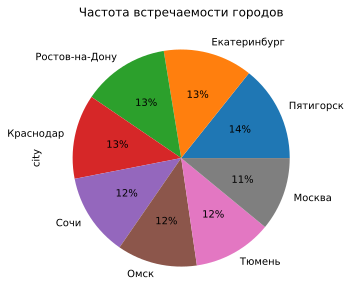

In [23]:
data_users_go['city'].value_counts().plot(
    kind = 'pie', 
    y = count_users_by_city,
    autopct = '%1.0f%%',
    figsize=(5,5), 
    title = 'Частота встречаемости городов');

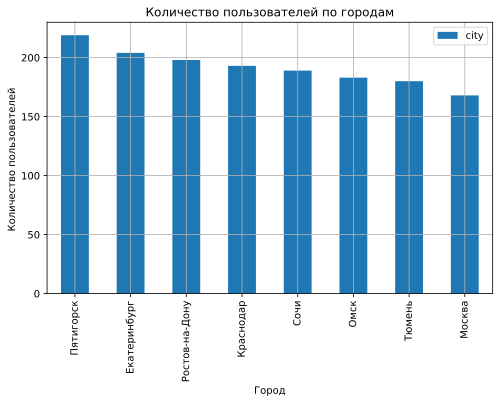

In [24]:
data_users_go['city'].value_counts().plot.bar(figsize=(8, 5), legend=True)
plt.title('Количество пользователей по городам')
plt.xlabel('Город')
plt.ylabel('Количество пользователей ')
plt.grid()
plt.show()

Частота встречаемости городов в приложении для аренды самокатов примерно одинакова. Больше всего пользователей в городе Пятигорск - 219 человек. Меньше всего пользователей в Москве - 168 человек. Наверное, это связано с тем, что Пятигорск меньше Москвы по площади, и там удобнее брать самокат для перемещения по городу.

### Cоотношение пользователей с подпиской и без подписки.

In [25]:
count_sub = data_users_go['subscription_type'].value_counts()

In [26]:
count_sub

free     835
ultra    699
Name: subscription_type, dtype: int64

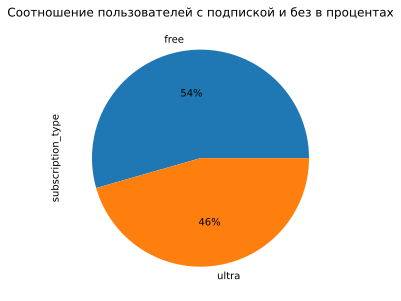

In [27]:
data_users_go['subscription_type'].value_counts().plot(
    kind = 'pie', 
    y = count_sub, 
    autopct = '%1.0f%%', 
    figsize=(5,5),
    title = 'Cоотношение пользователей с подпиской и без в процентах');

Больше половины пользователей (54%) используют бесплатную подписку - 835 человек. На платной подписке - 699 пользователей, что составляет 46% от общего числа пользователей.

### Возраст пользователей.

In [28]:
#Самые младшие пользователи.
data_users_go['age'].sort_values().head(10)

664     12
66      12
727     12
34      12
235     13
1249    13
314     13
83      13
553     13
1241    13
Name: age, dtype: int64

In [29]:
#Самые старшие пользователи.
data_users_go['age'].sort_values(ascending=False).head(10)

1201    43
961     39
804     38
453     38
383     38
205     37
848     37
721     36
1491    36
644     36
Name: age, dtype: int64

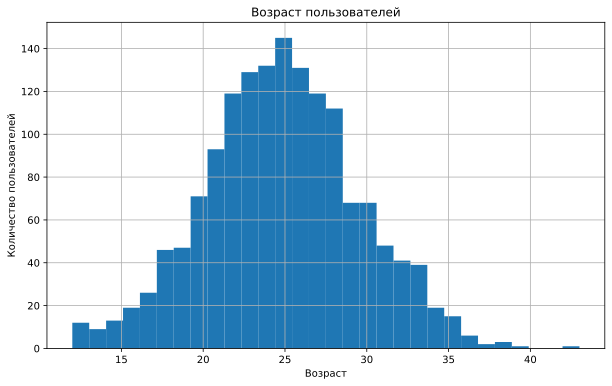

In [30]:
plt.hist(data_users_go['age'], bins = 30)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

Возраст пользователей приложения варьируется от 12 до 43 лет, но большинство пользователей находятся в возрасте от 20 до 30 лет.

### Расстояние, которое пользователь преодолел за одну поездку.

In [31]:
#Самые короткие расстояния.
round(data_rides_go['distance'].sort_values(), 2).head(10)

11555     0.86
9541      2.57
13690     4.33
8658      6.78
7841      7.10
8906     11.28
8324     12.23
13940    15.00
15626    15.37
11862    15.63
Name: distance, dtype: float64

In [32]:
#Самые длинные расстояния.
round(data_rides_go['distance'].sort_values(ascending=False), 2).head(10)

16309    7211.01
16484    7066.00
15580    6908.49
17171    6760.94
17242    6724.93
10341    6671.97
11385    6601.20
12086    6538.94
10915    6535.39
11319    6503.60
Name: distance, dtype: float64

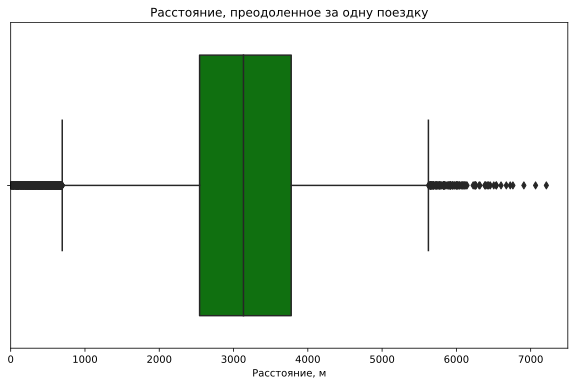

In [33]:
sns.boxplot(x=data_rides_go['distance'], color='green')
plt.title('Расстояние, преодоленное за одну поездку')
plt.xlabel('Расстояние, м')
_ = plt.xlim(0, 7500)

Самое короткое расстояние, которое пользователь преодолел за одну поездку, составило 0.86 км, а самое длинное - 7.2 км. Большинство пользователей проезжают от 2.5 км до 4 км.

### Продолжительность поездок.

In [34]:
#Самые короткие поездки.
data_rides_go['duration'].sort_values().head(10)

12013    0.5
17314    0.5
15029    0.5
7437     0.5
12967    0.5
15015    0.5
13012    0.5
7508     0.5
16589    0.5
9049     0.5
Name: duration, dtype: float64

In [35]:
#Самые продолжительные поездки.
data_rides_go['duration'].sort_values(ascending=False).head(10)

4215    40.823963
4709    39.873856
2623    39.526602
1998    38.352763
6453    38.265229
143     38.125729
3729    37.014141
499     36.906491
6348    36.809310
4653    36.622595
Name: duration, dtype: float64

In [36]:
#Общее время поездок и дистанция для каждого пользователя.
data_rides_go.groupby(['user_id']).sum(numeric_only = True)

,distance,duration,month
user_id,,,
1,34070.182066,204.604909,99
2,33964.058614,197.644279,67
3,36907.597866,233.193513,66
4,44837.189916,288.563581,107
5,35556.949649,174.073932,51
...,...,...,...
1530,46758.469822,292.366839,104
1531,67054.794222,408.192206,142
1532,33902.203192,212.160144,111


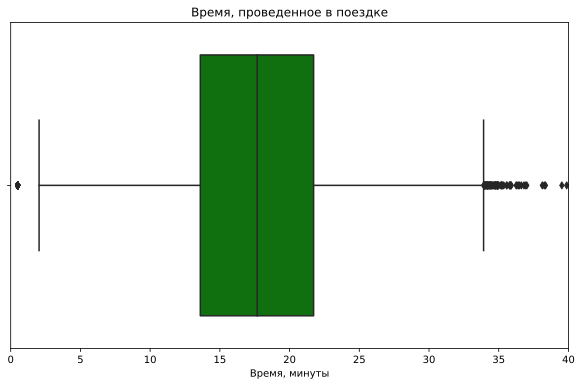

In [37]:
sns.boxplot(x = data_rides_go['duration'], color='green')
plt.title('Время, проведенное в поездке')
plt.xlabel('Время, минуты')
_ = plt.xlim(0, 40)

Самые короткие поездки занимают по пол минуты, что может быть связано с техническими проблемами или изменением планов пользователя. Самая длинная поездка заняла 40 минут. В основном же продолжительность поездки составляет 13 - 22 минуты.

**Вывод:** Частота встречаемости городов в приложении для аренды самокатов примерно одинакова. Больше всего пользователей в городе Пятигорск - 219 человек. Меньше всего пользователей в Москве - 168 человек. Наверное, это связано с тем, что Пятигорск меньше Москвы по площади, и там удобнее брать самокат для перемещения по городу.

Больше половины пользователей (54%) используют бесплатную подписку - 835 человек. На платной подписке - 699 пользователей, что составляет 46% от общего числа пользователей.

Возраст пользователей приложения варьируется от 12 до 43 лет, но большинство пользователей находятся в возрасте от 20 до 30 лет.

Самое короткое расстояние, которое пользователь преодолел за одну поездку, составило 0.86 км, а самое длинное - 7.2 км. Большинство пользователей проезжают от 2.5 км до 4 км.

Самые короткие поездки занимают по пол минуты, что может быть связано с техническими проблемами или изменением планов пользователя. Самая длинная поездка заняла 40 минут. В основном же продолжительность поездки составляет 13 - 22 минуты.

## Шаг 4. Объединение данных

### Объединение данных в одну таблицу.

In [38]:
#Объединим данные о пользователях, поездках и подписках в один датафрейм с помощью метода merge.

In [39]:
full_data = data_users_go.merge(data_rides_go)

In [40]:
full_data = full_data.merge(data_subscriptions_go)

In [41]:
full_data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


### Создание датафрейма с данными о пользователях без подписки.

In [42]:
free_sub = full_data.query("`subscription_type` == 'free'")
print(free_sub)

       user_id     name  age       city subscription_type     distance  \
6500       700    Айдар   22       Омск              free  2515.690719   
6501       700    Айдар   22       Омск              free   846.932642   
6502       700    Айдар   22       Омск              free  4004.434142   
6503       700    Айдар   22       Омск              free  1205.911290   
6504       700    Айдар   22       Омск              free  3047.379435   
...        ...      ...  ...        ...               ...          ...   
18063     1534  Альберт   25  Краснодар              free  3781.098080   
18064     1534  Альберт   25  Краснодар              free  2840.423057   
18065     1534  Альберт   25  Краснодар              free  3826.185507   
18066     1534  Альберт   25  Краснодар              free  2902.308661   
18067     1534  Альберт   25  Краснодар              free  2371.711192   

        duration       date  month  minute_price  start_ride_price  \
6500   14.944286 2021-01-02      1       

### Визуализация информации о расстоянии на бесплатном тарифе.

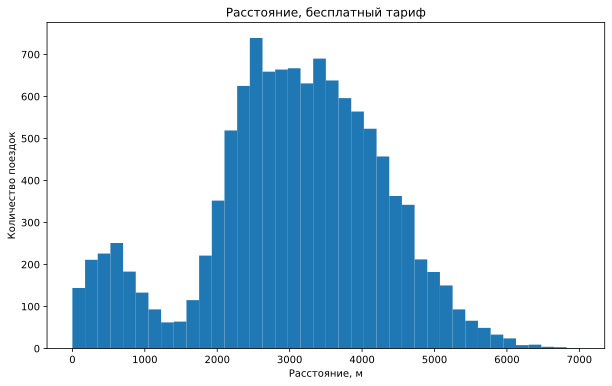

<Figure size 1600x1600 with 0 Axes>

In [43]:
plt.hist(free_sub['distance'], bins=40, range = (0, 7000))
plt.title('Расстояние, бесплатный тариф')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

### Визуализация информации о времени на бесплатном тарифе.

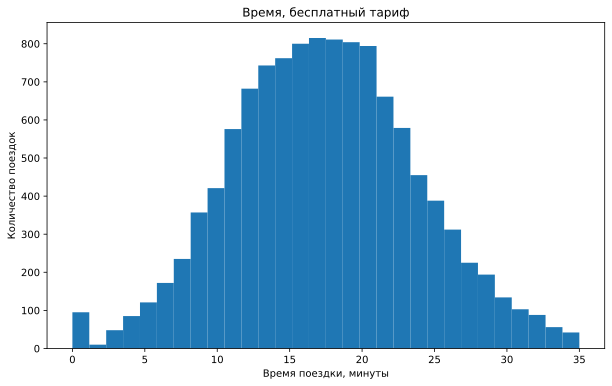

<Figure size 1600x1600 with 0 Axes>

In [44]:
plt.hist(free_sub['duration'], bins=30, range = (0, 35))
plt.title('Время, бесплатный тариф')
plt.xlabel('Время поездки, минуты')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

### Создание датафрейма с данными о пользователях с подпиской Ultra.

In [45]:
ultra_sub = full_data.query("`subscription_type` == 'ultra'")
print(ultra_sub)

      user_id    name  age    city subscription_type     distance   duration  \
0           1    Кира   22  Тюмень             ultra  4409.919140  25.599769   
1           1    Кира   22  Тюмень             ultra  2617.592153  15.816871   
2           1    Кира   22  Тюмень             ultra   754.159807   6.232113   
3           1    Кира   22  Тюмень             ultra  2694.783254  18.511000   
4           1    Кира   22  Тюмень             ultra  4028.687306  26.265803   
...       ...     ...  ...     ...               ...          ...        ...   
6495      699  Оксана   22  Москва             ultra  3973.046497  24.671163   
6496      699  Оксана   22  Москва             ultra  3288.702563  15.892886   
6497      699  Оксана   22  Москва             ultra  3076.159348  14.389525   
6498      699  Оксана   22  Москва             ultra  4707.845501  15.839579   
6499      699  Оксана   22  Москва             ultra  3202.890770  25.217345   

           date  month  minute_price  s

### Визуализация информации о расстоянии на платном тарифе Ultra.

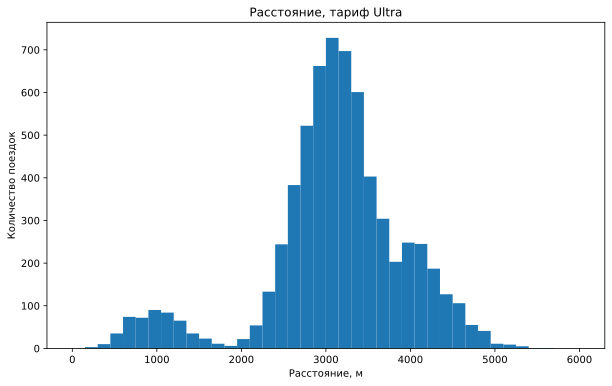

<Figure size 1600x1600 with 0 Axes>

In [46]:
plt.hist(ultra_sub['distance'], bins=40, range = (0, 6000))
plt.title('Расстояние, тариф Ultra')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

### Визуализация информации о времени на платном тарифе Ultra.

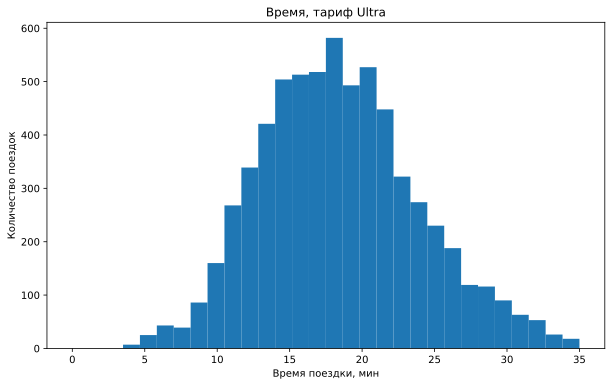

<Figure size 1600x1600 with 0 Axes>

In [47]:
plt.hist(ultra_sub['duration'], bins=30, range = (0, 35))
plt.title('Время, тариф Ultra')
plt.xlabel('Время поездки, мин')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

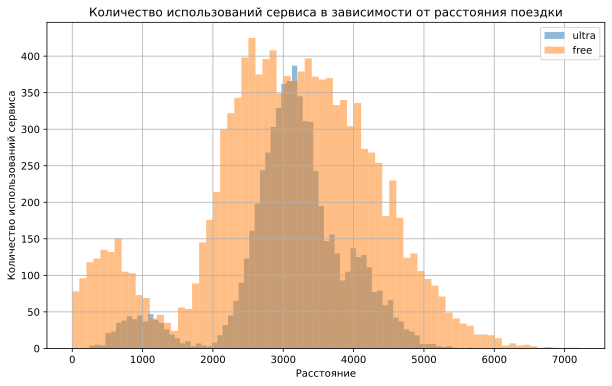

In [48]:
def quantity_go_comparison(ultra_sub, free_sub, distance_col, max_distance, xlabel, ylabel, title, ultra_label, free_label):
    ultra_hist = ultra_sub[distance_col].hist(bins=int(max_distance), label=ultra_label, alpha=0.5)
    free_hist = free_sub[distance_col].hist(bins=int(max_distance), label=free_label, alpha=0.5)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    plt.show()

quantity_go_comparison(
    ultra_sub, 
    free_sub, 
    'distance', 
    int(free_sub['distance'].max()/100), 
    'Расстояние', 
    'Количество использований сервиса', 
    'Количество использований сервиса в зависимости от расстояния поездки', 
    'ultra', 
    'free'
)

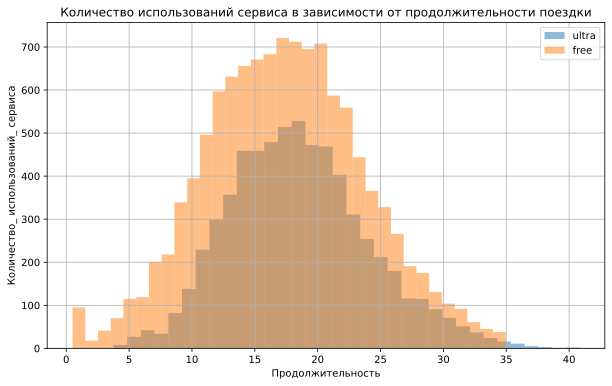

In [49]:
def quantity_go_comparison(ultra_sub, free_sub, duration_col, max_duration, xlabel, ylabel, title, ultra_label, free_label):
    ultra_hist = ultra_sub[duration_col].hist(bins=int(max_duration), label=ultra_label, alpha=0.5)
    free_hist = free_sub[duration_col].hist(bins=int(max_duration), label=free_label, alpha=0.5)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    plt.show()

quantity_go_comparison(
    ultra_sub,
    free_sub,
    'duration',
    int(free_sub['duration'].max()),
    'Продолжительность',
    'Количество_ использований_ сервиса',
    'Количество использований сервиса в зависимости от продолжительности поездки',
    'ultra',
    'free')

**Вывод:** Объединили данные о пользователях, поездках и тарифах в один датафрейм, который назвали full_data. Затем выделили два отдельных датафрейма на основе full_data: free_sub, содержащий информацию о пользователях с бесплатным тарифом, и ultra_sub, содержащий информацию о пользователях с платным тарифом.

Визуализировали информацию о расстоянии и времени для каждого из тарифов. Для бесплатного тарифа время поездки составляет от 10 до 30 минут, и проезжают от 2 до 5 км, есть пользователи, которые проехали 6, 6.5 км.

Для платного тарифа время укладывается в промежуток от 15 до 25 минут. Пик расстояния приходится на 3 км.

Таким образом, можно сделать вывод, что пользователи с бесплатным тарифом в целом совершают более долгие поездки и проезжают большее расстояние, чем пользователи на платном тарифе.

## Шаг 5. Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках на основе объединенных данных из предыдущего шага. Для этого используем сводную таблицу, чтобы найти суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [50]:
#Добавим значения переменных для каждого из тарифов:
#subscription_type = free
fee_free = 0 #Абонентская плата.
emp_free = 8 #Стоимость каждой минуты использования.
startpay_free = 50 #Стоимость старта.

#subscription_type = Ultra
fee_ultra = 199 #Абонентская плата.
emp_ultra = 6 #Стоимость каждой минуты использования.
startpay_ultra = 0 #Стоимость старта.

In [51]:
#Округлим значения длительности поездки до ближайшего целого.
full_data['duration'] = np.ceil(full_data['duration'])

In [52]:
total_data = pd.pivot_table(full_data, index=['month', 'user_id'],
                           values = ['distance', 'duration', 'name', 'subscription_type'],
                           aggfunc = {'distance': sum, 'duration' : sum, 'name' : len, 'subscription_type' : min})

In [53]:
total_data.rename(columns = {'name' : 'count_name'}, inplace = True)

In [54]:
total_data.sort_values(by='month').head(10)

distance  duration  count_name subscription_type
month user_id                                                      
1     1         7027.511294      42.0           2             ultra
      1061     12637.249630      43.0           3              free
      1063      3276.362299      10.0           1              free
      1064      5297.324649      15.0           1              free
      1065     14547.099333      99.0           4              free
      1066      2809.064949      19.0           1              free
      1067      3864.900780      22.0           1              free
      1069      7007.076943      53.0           3              free
      1071      3635.094136      15.0           1              free
      1072      2498.615999      11.0           1              free

In [55]:
#Добавим столбец с выручкой за месяц.
def revenue(row):
    if row['subscription_type'] == 'ultra':
        return emp_ultra * row['duration'] + fee_ultra
    elif row['subscription_type'] == 'free':
        return emp_free * row['duration'] + startpay_free * row['count_name']
    else:
        return 'Not subscription type'
    

total_data['revenue_per_month'] = total_data.apply(revenue, axis=1)
total_data.head()

distance  duration  count_name subscription_type  \
month user_id                                                        
1     1        7027.511294      42.0           2             ultra   
      3        3061.777147      13.0           1             ultra   
      5        3914.646990      13.0           1             ultra   
      7        6478.080979      28.0           2             ultra   
      12       3577.151148      33.0           1             ultra   

               revenue_per_month  
month user_id                     
1     1                    451.0  
      3                    277.0  
      5                    277.0  
      7                    367.0  
      12                   397.0

**Вывод:** Создали новый датафрейм с агрегированными данными, который назвали total_data. Этот датафрейм был создан на основе объединенных данных из предыдущего шага. В total_data нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Кроме того, добавили столбец с помесячной выручкой, которую принес каждый пользователь.

## Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов, которые мы проанализируем с помощью проверок нескольких гипотез:

* тратят ли пользователи с подпиской больше времени на поездки?
* превышает ли среднее расстояние, которое проезжают пользователи с подпиской за одну поездку 3130 м?
* помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки?

### Проверка гипотезы: тратят ли пользователи с подпиской больше времени на поездки?

Проверим гипотезу о том, что пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе. Нулевая гипотеза будет утверждать, что время использования самоката с типом подписки Ultra равно времени использования самоката с типом подписки free. Альтернативная гипотеза будет утверждать, что время использования самоката с типом подписки Ultra больше времени использования самоката с типом подписки free.

In [56]:
ultra = ultra_sub['duration'] 
free = free_sub['duration']
results = st.ttest_ind(ultra, free, alternative = 'greater')
alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

good_data_free_mean=free_sub['duration'].mean().round(2)
good_data_ultra_mean=ultra_sub['duration'].mean().round(2)    
print(f'среднее значение для столбца с длительностью поездки в тарифом free = {good_data_free_mean}')
print(f'среднее значение для столбца с длительностью поездки в тарифом Ultra = {good_data_ultra_mean}')

1.2804098316645618e-34
Отвергаем нулевую гипотезу
среднее значение для столбца с длительностью поездки в тарифом free = 17.39
среднее значение для столбца с длительностью поездки в тарифом Ultra = 18.54


**Вывод:** Проверили гипотезу и отвергли предположение о том, что время поездки пользователей на тарифе Ultra равно времени поездки пользователей на тарифе free.

### Проверка гипотезы: превышает ли среднее расстояние, которое проезжают пользователи с подпиской за одну поездку 3130 м?

Проверим гипотезу о том, превышает ли среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, отметку в 3130 метров. Нулевая гипотеза будет утверждать, что среднее расстояние на подписке Ultra равно 3130 метрам. Альтернативная гипотеза будет утверждать, что среднее расстояние на подписке Ultra меньше 3130 метров.

Нулевая гипотеза утверждает, что среднее расстояние поездок с подпиской Ultra равно 3130 метров. Альтернативная гипотеза предполагает, что среднее расстояние поездок с подпиской Ultra больше 3130 метров.

In [57]:
data_ultra_dist = ultra_sub['distance']

hipo_value = 3130.0
alpha = 0.05

results = st.ttest_1samp(data_ultra_dist, hipo_value, alternative='greater')
    
print(results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')


data_ultra_dist_mean = ultra_sub['distance'].mean().round(2)

print(f'среднее значение для столбца с расстоянием одной поездки в тарифом Ultra = {data_ultra_dist_mean}')

0.9195368847849785
Не удалось отвергнуть нулевую гипотезу
среднее значение для столбца с расстоянием одной поездки в тарифом Ultra = 3115.45


**Вывод:** Проверили гипотезу и не можем утверждать, что среднее расстояние, которое проезжают пользователи с подпиской Ultra, не превышает 3130 метров.

### Проверка гипотезы: помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки?

Нам важно понять, тратят ли пользователи с подпиской больше времени на поездки. Если это так, то пользователи с подпиской могут быть более выгодными для компании. Мы проверим эту гипотезу. Нулевая гипотеза будет утверждать, что выручка пользователей за месяц на подписке Ultra равна выручке за месяц пользователей на подписке free. Альтернативная гипотеза будет утверждать, что выручка пользователей за месяц на подписке Ultra больше выручки за месяц пользователей на подписке free.

In [58]:
data_ultra_per_month = total_data.loc[total_data['subscription_type'] == 'ultra', 'revenue_per_month']
                        
data_free_per_month = total_data.loc[total_data['subscription_type'] == 'free', 'revenue_per_month'] 


results = st.ttest_ind(data_ultra_per_month, data_free_per_month, alternative = 'greater')
alpha = 0.05
print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

1.8850394384715216e-31
Отвергаем нулевую гипотезу


In [59]:
mean_free = data_free_per_month.mean().round(2)
mean_ultra = data_ultra_per_month.mean().round(2)

print("Средняя выручка в месяц для пользователей с подпиской типа free:", mean_free)
print("Средняя выручка в месяц для пользователей с подпиской типа ultra:", mean_ultra)

Средняя выручка в месяц для пользователей с подпиской типа free: 328.64
Средняя выручка в месяц для пользователей с подпиской типа ultra: 362.79


**Вывод:** Проверили гипотезу и можем утверждать, что выручка с пользователей на подписке Ultra превышает выручку с пользователей на подписке free.

### Проверка гипотезы: снизилось ли количество обращений в тех поддержку после обновления сервера.

Представим следующую ситуацию: техническая команда сервиса обновила серверы, с которыми взаимодействует мобильное приложение. Команда надеется, что после обновления количество обращений в техническую поддержку значительно уменьшится. У нас есть файл, который содержит данные о количестве обращений для каждого пользователя до обновления и после него.

Поскольку у нас есть две выборки данных, которые зависят от факта обновления серверов, я предполагаю, что здесь следует применить гипотезу о равенстве средних значений количества обращений в техническую поддержку до и после изменения для парных выборок.

За нулевую гипотезу возьмем: Среднее значение первой выборки равно среднему значению второй выборки.
За альтернативную гипотезу: Среднее значение первой выборки не равно среднему значению второй выборки.
Для этого нам потребуется использовать метод scipy.stats.ttest_rel().

## Шаг 7. Распределения

### Задача 1.

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Биномиальное распределение описывает вероятность успеха в серии независимых бинарных экспериментов. В данном случае мы хотим определить количество клиентов, продлевающих подписку после бесплатного периода, при условии, что вероятность продления подписки равна 10%.

Чтобы определить минимальное количество промокодов, нам нужно найти значение параметра N (количество промокодов), при котором вероятность не выполнить план (менее 100 клиентов продлевают подписку) составляет около 5%.

Для этого мы можем построить график распределения с использованием различных значений параметра N и найти такое значение, при котором вероятность опережения не выполнения плана составляет около 5%.

In [60]:
#Вероятность успешного продления подписки.
p = 0.1
#Количество продлений подписки.
k = 100

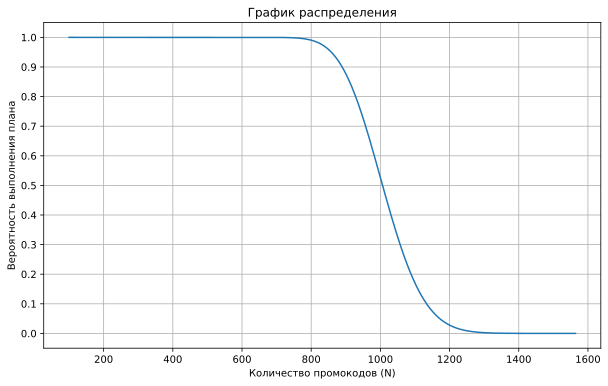

In [61]:
N_values = range(100, 1565) 
#Возьмем за максимальное значение количество строк в изначальной таблице.
cdf_values = [st.binom.cdf(k, N, p) for N in N_values] 

plt.plot(N_values, cdf_values) 
plt.yticks(np.arange(min(cdf_values), max(cdf_values)+0.1, 0.1))

plt.xlabel('Количество промокодов (N)')
plt.ylabel('Вероятность выполнения плана') 
plt.title('График распределения')
plt.grid(b=True)

plt.show() 

По графику можно предположить, что количество промокодов, которые необходимо разослать, примерно равно 1000.

Чтобы найти более точное значение параметра N, при котором вероятность не выполнить план (менее 100 продлений подписки) составляет около 5%, мы можем использовать функцию np.abs() для нахождения ближайшего значения к 0.05 (5%) и функцию np.argmin(), которая возвращает массив, содержащий индексы минимальных элементов.

In [62]:
N_value = N_values[np.abs(np.array(cdf_values) - 0.05).argmin()] 
print("Минимальное количество промокодов для отправки = ", N_value) 

Минимальное количество промокодов для отправки =  1172


**Вывод:** Минимальное количество промокодов для отправки =  1172.

In [63]:
n = 1000  # Начальное количество промокодов.
p = 0.1   # Вероятность успеха (продление подписки).
k = 99    # Количество клиентов, которых мы хотим достичь (100, но из-за округления используем 99).
binom_cdf = 0.05  # Вероятность невыполнения плана.

# Поиск минимального количества.
while binom_cdf < stats.binom.cdf(k, n, p):
    n += 1

print(f"Минимальное количество промокодов: {n}")

Минимальное количество промокодов: 1161


Для того чтобы как минимум 100 клиентов продлили подписку после получения промокода, необходимо разослать промокоды как минимум 1161 подписчикам. Вероятность невыполнения плана составляет 5%.

### Задача 2.

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Нам нужно определить количество клиентов, которые откроют уведомление после того, как мы разошлем 1 миллион уведомлений. При этом мы знаем, что вероятность открытия одного уведомления составляет 0.4 (40%).

In [64]:
n = 1000000 #Общее количество испытаний (уведомлений).
p = 0.4 #Вероятность успеха в одном испытании (открытие уведомления).
k = 399500 #Количество успехов.

In [65]:
#Вычислим среднее значение и стандартное отклонение нормального распределения.
mu = n * p
sigma = np.sqrt(n * p * (1 - p))

print('mu =',mu)
print('sigma =',sigma)

mu = 400000.0
sigma = 489.89794855663564


In [66]:
#Оцениваем вероятность того, что не более 399500 уведомлений будут открыты.
p_hipo = st.norm.cdf(399500, mu, sigma)
p_hipo = "{:.2%}".format(p_hipo)

print("Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей:", p_hipo)

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей: 15.37%


Вероятность открытия сообщений: 0.15371708296369768


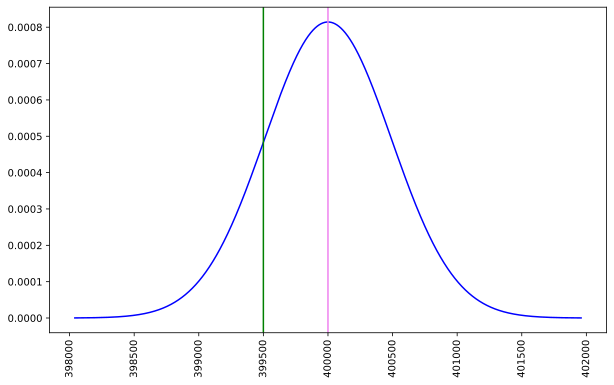

In [67]:
#Задаём нормальное распределение.
distr = st.norm(mu, sigma) 

#Считаем вероятность хвоста слева от 399.5 тысяч.
result = distr.cdf(k)
print('Вероятность открытия сообщений:', result)

arange = np.arange((mu - 4 * sigma),(mu + 4 * sigma),1)
plt.plot(arange, st.norm.pdf(arange, mu, sigma), 'b-')
plt.xticks(rotation=90)
plt.axvline(x=k, color='green')
plt.axvline(x=mu, color='violet')
plt.show()

**Вывод:** Если разослать 1 миллион уведомлений, при условии, что только 40% получивших клиентов откроют их, то вероятность того, что уведомление откроют не более 399,500 пользователей, составит 0.1537 или 15,37%.

## Общий вывод.

Загрузили три датасета: с пользователями, информацией о поездках и информацией о подписках. Проверили данные на наличие пропусков, их не оказалось. Изменили тип данных столбца date в датасете data_rides на тип даты и добавили столбец month с номером месяца. Удалили дубликаты строк из датасета с пользователями.

Провели исследовательский анализ данных:

Вывели, что количество пользователей по городам распределено примерно одинаково, нет выдающихся значений. Лидером по количеству пользователей является Пятигорск - 219 пользователей. Меньше всего пользователей в Москве - 168. Пользователей, использующих бесплатную подписку больше - 835 человек, что составляет ~54% от общего числа пользователей. На платной подписке сидит 699 пользователей, что составляет ~46%. Возраст пользователей укладывается в промежуток от 20 до 30 лет. В основном пользователи проезжают от 2.5 км до 4 км. Чаще всего длительность поездки составляет 13 - 22 минуты. Объединили данные о пользователях, поездках и подписках в один датасет. На основе объединенного датасета создали еще два датасета: для пользователей с Ultra подпиской и для пользователей с free подпиской. Дальше визуализировали информацию о расстоянии и времени поездки для пользователей каждого тарифа.

Для бесплатного тарифа время поездки составляет от 10 до 30 минут, и проезжают от 2 до 5 км, есть пользователи, которые проехали даже 6, 6.5 км. Платный тариф. В основном время укладывается в промежуток от 15 до 25 минут. Пик расстояния приходится на 3 км.

Нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц - вывели все данные в отдельный датасет total_data. Добавили в датасет total_data столбец с помесячной выручкой revenue_per_month.

Проверили гипотезы:

Пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе. Отвергли нулевую гипотезу. Пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку. Не удалось отвергнуть нулевую гипотезу. Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки. Отвергли нулевую гипотезу.

Проект успешно выполнен. Изучили данные сервиса аренды самокатов GoFast и проверили ряд гипотез, которые могут способствовать развитию бизнеса.


Все начальные данные во всех файлах были полными, без больших отклонений и дубликатов, за исключением тех, которые были найдены в файле ‘users_go.csv’. Когда данные были скопированы из файлов в таблицы, столбцы данных не были в наилучшем состоянии. В процессе предварительной обработки данные были оптимизированы для целей данного проекта.

В результате исследования данных было установлено следующее:

Вывели, что количество пользователей по городам распределено примерно одинаково, нет выдающихся значений. Лидером по количеству пользователей является Пятигорск - 219 пользователей. Меньше всего пользователей в Москве - 168.

Пользователей, использующих бесплатную подписку больше - 835 человек, что составляет ~54% от общего числа пользователей. На платной подписке сидит 699 пользователей, что составляет ~46%. 

Возраст пользователей укладывается в промежуток от 20 до 30 лет. 

В основном пользователи проезжают от 2.5 км до 4 км. 

Чаще всего длительность поездки составляет 13 - 22 минуты. 

Объединили данные о пользователях, поездках и подписках в один датасет. На основе объединенного датасета создали еще два датасета: для пользователей с Ultra подпиской и для пользователей с free подпиской. Дальше визуализировали информацию о расстоянии и времени поездки для пользователей каждого тарифа.

Для бесплатного тарифа время поездки составляет от 10 до 30 минут, и проезжают от 2 до 5 км, есть пользователи, которые проехали даже 6, 6.5 км. Платный тариф. В основном время укладывается в промежуток от 15 до 25 минут. Пик расстояния приходится на 3 км.

Нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц - вывели все данные в отдельный датасет total_data. Добавили в датасет total_data столбец с помесячной выручкой revenue_per_month.

Проверили гипотезы:

Пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе. Отвергли нулевую гипотезу. Пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку. Не удалось отвергнуть нулевую гипотезу. Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки. Отвергли нулевую гипотезу.

В задачах на распределение подсчитали:

Для достижения цели по продлению подписки необходимо разослать 1169 промокодов, учитывая, что вероятность продления подписки составляет 10%. Это позволит достичь цели в 100 продленных подписок с вероятностью неуспеха не более 5%.

Если разослать миллион уведомлений клиентам, которые открывают их с вероятностью 40%, то ожидаемое количество открытых уведомлений составит 399,5 тысяч.